In [85]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.activation.functions import Relu,Linear
from allison.optimizers.sgd import SGD,SGDMomentum
from allison.base.tensor import Tensor,no_grad

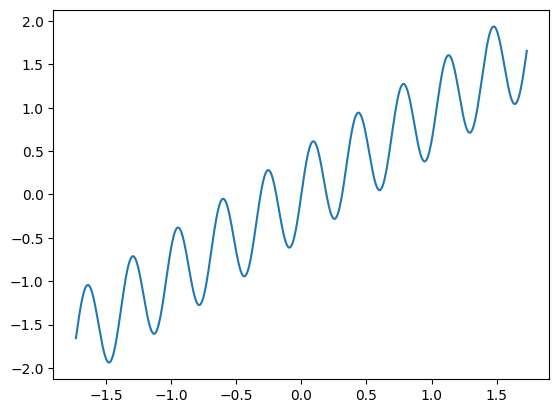

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
points = 1000
x1 = np.linspace(0, 20*np.pi, points)
x2 = np.linspace(0, 20*np.pi, points)

# Definimos la salida
y = 10*np.sin(x1) + x2


# %%
# Normalización
X_np = np.stack([x1, x2], axis=1)
X_mean, X_std = X_np.mean(axis=0), X_np.std(axis=0)
X_norm = (X_np - X_mean) / X_std

y_mean, y_std = y.mean(), y.std()
y_norm = (y - y_mean) / y_std

X = Tensor(X_norm)
Y = Tensor(y_norm.reshape(-1, 1)) # Asegúrate de que Y tenga la misma forma que Y_pred

plt.plot(X.data[:,0],Y.data)
plt.show()


In [87]:
def r2_score(Y, y_pred):
    sr = np.mean((y_pred.data - Y.data)**2)
    sy = np.mean((Y.data - np.mean(Y.data))**2)

    return 1-(sr/sy)

In [88]:
class MSELoss:
    def __call__(self, Y, y_pred):
        return ((Y - y_pred) * (Y - y_pred)).mean()

In [89]:
class AllisonNet:
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError("Debes implementar forward en la subclase.")

    def parameters(self):
        params = []

        def _gather_params(obj):
            # Recorre atributos
            if isinstance(obj, Linear):
                params.extend([obj.W, obj.b])
            elif isinstance(obj, AllisonNet):  # Si es un submodelo
                params.extend(obj.parameters())
            elif isinstance(obj, (list, tuple)):
                for layer in obj:
                    _gather_params(layer)
            elif isinstance(obj, dict):
                for layer in obj.values():
                    _gather_params(layer)

        for layer in self.__dict__.values():
            _gather_params(layer)

        return params

    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)


class Network(AllisonNet):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()



criterion = MSELoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)


Epoch 0 | Loss: 4.2137 | R2: -321.366%
Epoch 10 | Loss: 1.2945 | R2: -29.447%
Epoch 20 | Loss: 0.5003 | R2: 49.973%
Epoch 30 | Loss: 0.2629 | R2: 73.710%
Epoch 40 | Loss: 0.1615 | R2: 83.850%
Epoch 50 | Loss: 0.1401 | R2: 85.987%
Epoch 60 | Loss: 0.1394 | R2: 86.065%
Epoch 70 | Loss: 0.1390 | R2: 86.100%
Epoch 80 | Loss: 0.1387 | R2: 86.132%
Epoch 90 | Loss: 0.1383 | R2: 86.173%
Epoch 100 | Loss: 0.1380 | R2: 86.199%
Epoch 110 | Loss: 0.1379 | R2: 86.210%
Epoch 120 | Loss: 0.1378 | R2: 86.218%
Epoch 130 | Loss: 0.1378 | R2: 86.224%
Epoch 140 | Loss: 0.1377 | R2: 86.230%
Epoch 150 | Loss: 0.1376 | R2: 86.236%
Epoch 160 | Loss: 0.1376 | R2: 86.242%
Epoch 170 | Loss: 0.1375 | R2: 86.247%
Epoch 180 | Loss: 0.1375 | R2: 86.252%
Epoch 190 | Loss: 0.1374 | R2: 86.257%
Epoch 200 | Loss: 0.1374 | R2: 86.262%
Epoch 210 | Loss: 0.1373 | R2: 86.266%
Epoch 220 | Loss: 0.1373 | R2: 86.271%
Epoch 230 | Loss: 0.1373 | R2: 86.275%
Epoch 240 | Loss: 0.1372 | R2: 86.279%
Epoch 250 | Loss: 0.1372 | R2: 86

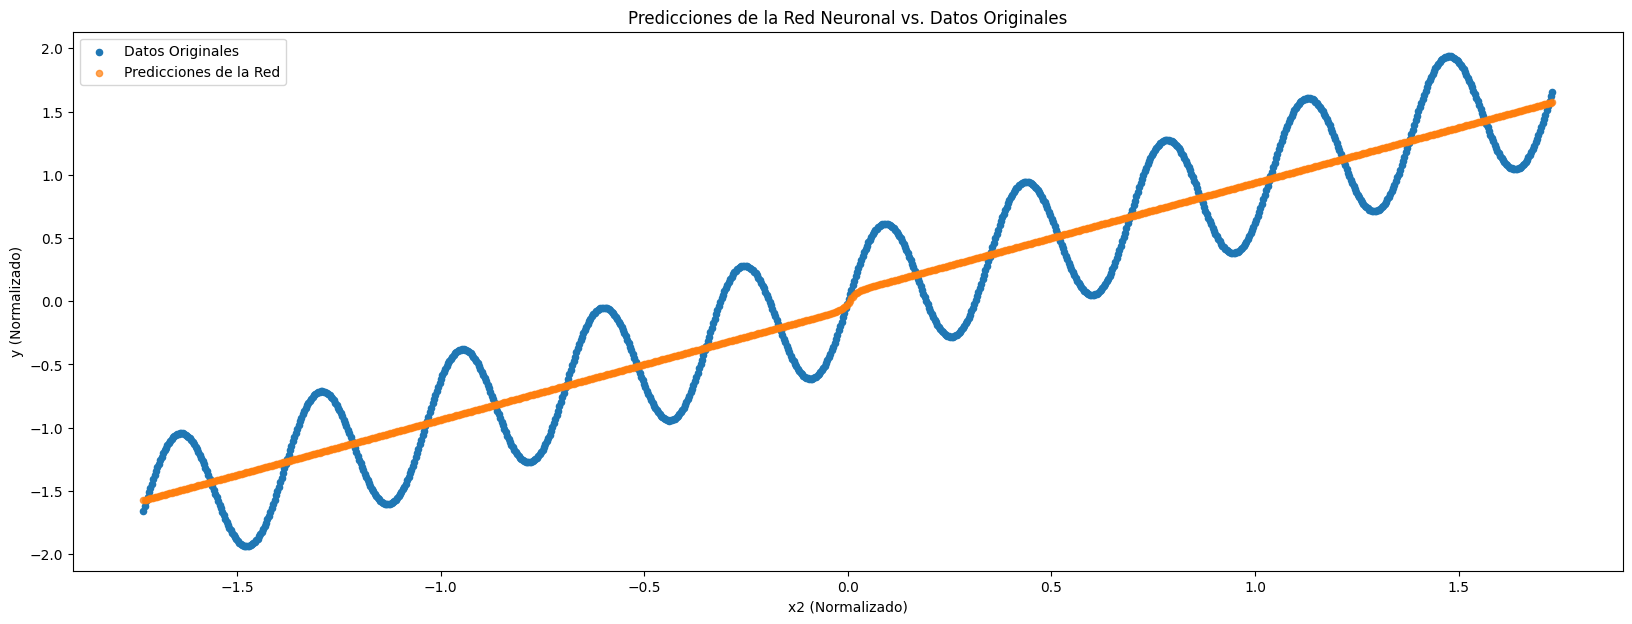

In [90]:

# %%
# Bucle de entrenamiento mejorado
for epoch in range(1000 + 1):
    Y_pred = net(X)

    # Calcular la pérdida MSE y luego la media
    # loss = ((Y_pred - Y) * (Y_pred - Y)).mean()
    loss = criterion(Y,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        r2 = r2_score(Y, Y_pred)
        print(f"Epoch {epoch} | Loss: {loss.data:.4f} | R2: {100*r2:.3f}%")
        if r2 > 0.99:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

# %%
# Visualización final

with no_grad():
    y_pred = net(X)

plt.figure(figsize=(20, 7))
plt.scatter(X.data[:, 1], Y.data, label='Datos Originales', s=20)
plt.scatter(X.data[:, 1], y_pred.data, label='Predicciones de la Red', s=20, alpha=0.7)
plt.title('Predicciones de la Red Neuronal vs. Datos Originales')
plt.xlabel('x2 (Normalizado)')
plt.ylabel('y (Normalizado)')
plt.legend()
plt.show()
